<a href="https://colab.research.google.com/github/ZetaRR/NY-apartments-EDA-Regression-project/blob/main/EDA%26Building_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation & Import of required libraries

In [ ]:
!pip install squarify
!pip install --upgrade pandas
!pip install shap 

In [ ]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as FF
from plotly import tools
import plotly.graph_objs as go
import plotly.express as px
import folium
import squarify
import plotly
from google.colab import drive,files # required to connect google disk
import pandas_profiling as pp
import plotly.figure_factory as ff
import missingno as msno
from scipy.stats import skew, kurtosis
from datetime import datetime
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold



plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.family'] = "monospace"

colors = ["#000000", "#FF7863", "#4e4151", "#dbba78", "#bb9c55", "#909195","#dc1e1e","#a02933","#716807","#717cb4"]

matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore")
%matplotlib inline

# Structure Investigation


In [ ]:
pd.set_option('display.max_columns', None)
drive.mount('/drive', force_remount=False) # mounting google drive

df = pd.read_csv('/drive/MyDrive/df_to_csv/zillow_df.csv') # importing from Google Drive Zillow_DF that I got retrieved using API 
print('Shape of df: ', df.shape)
print('Dimensions: ', df.ndim)
df.head(3)

In [ ]:
num_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
print('Number of numerical variables: ', len(num_cols))
print(100*'-')
print('Numerical Features Ciolumns: ', num_cols)

In [ ]:
cat_cols = [col for col in df.columns if df[col].dtype not in ['float64', 'int64']]
print('Number of categorical variables: ', len(cat_cols))
print(100*'-')
print('Categorical Features Ciolumns: ', cat_cols)

In [ ]:
df.describe().T.style.background_gradient(axis=0, cmap='Set2')

In [ ]:
plt.figure(figsize=(14,5))
dataTypes = pd.DataFrame(df.dtypes.value_counts()).reset_index().rename(columns={'index':'variableType', 0:"count"})

sns.barplot(data=dataTypes, 
            x='variableType', 
            y="count",
            color=colors[2])
plt.title('DataTypes', 
          color=colors[2], 
          fontsize=16)
plt.xlabel('Variable Types')
plt.ylabel('Count')
plt.show();

In [ ]:
df_null = pd.DataFrame(len(df['propertyType']) - df.isnull().sum(), columns=['count'])
df_null = df_null[df_null['count'] != 160] # to filter out features that do not have any missing values

fig = go.Figure(data=[go.Bar(x=df_null.index, 
                             y=df_null['count'], opacity=0.9)])
fig.update_traces(marker_color='lightgrey', 
                  marker_line_color=colors[0])
fig.update_layout(title_text="Missing values",
                  paper_bgcolor='rgb(233,233,233)')

fig.show(renderer="colab") # renderer="colab" used specifically to present figure in Google Colab 

In [ ]:
df_temp = df.sort_values(by='rentZestimate') # determining if values missing at random or not 
msno.matrix(df)

**Dropping features and correcting names of features**

*Reasons why certain columns are dropped:*

*   dateSold = do not present valuable information that can help in prediction of price 
*   lotAreaValue = missing values >90%
*   propertyType = "Apartment" type only, due to filtering out only apartments
when getting data using API
*   daysonZillow = do not present valuable information that can help in prediction of price 
*   listingDateTime = missing values >90%
*   contingentListingType = missing values >90%
*   listingStatus = do not present valuable information that can help in prediction of price 
*   imgSrc = do not present valuable information that can help in prediction of price 
*   lotAreaUnit = missing values >90%
*   country = "USA" only
*   currency = "USD" only
*   hasImage = do not present valuable information that can help in prediction of price 
*   listingSubType.is_FSBA = do not present valuable information that can help in prediction of price 
*   listingSubType.is_openHouse = missing values >90%
*   isListedByOwner = do not present valueble infromation, 100% of apartments are listed by Agencies.
*   listingSubType.is_foreclosure = do not present valuable information that can help in prediction of price 


*Also, some columns are renamed in order to make it easier to navigate through them and work with dataframe*











In [ ]:
df.drop(['dateSold', 'lotAreaValue', 'propertyType', 'daysOnZillow', 'listingDateTime','contingentListingType',
          'listingStatus', 'imgSrc', 'lotAreaUnit', 'country', 'currency',
          'hasImage', 'listingSubType.is_FSBA',
          'listingSubType.is_openHouse', 'isListedByOwner',
          'listingSubType.is_foreclosure'], axis=1, inplace=True)

df.rename(columns={'livingArea':'living_area',
                   'propertyTaxRate':'property_tax_rate',
                   'timeOnZillow':'time_on_zillow',
                   'annualHomeownersInsurance':'annual_insurance',
                   'rentZestimate':'rent_estimate',
                   'yearBuilt':'year_built',
                   'pageViewCount':'page_view_count', 
                   'listingProvider.postingGroupName':'listed_by',
                   'resoFacts.cityRegion':'city_region',
                   'resoFacts.hasCooling':'cooling',
                   'resoFacts.hasView':'view'}, inplace=True, errors='ignore')

print('Shape of df after dropping:', df.shape)
df.head(2)


***Imputing missing values***

A couple code cells above I have used missingno library in order to determine that values are missing Randomly. Therefore, as next step distribution of values should be determined in order to select which values to impute on place of missing values.

*Rent* Estimate and *Living Area* are skewed, then it is better use median, while *Year Built* feature is not skewed, therefore mean will be used to impute.


In [ ]:
df = df.drop(df[df.living_area > 10000].index) # there are some anomalies higher than this values, and I do not have enough data analyse and predict also them

fig = make_subplots(rows=2, cols=2 ,specs=[[{}, {}],
                                           [{"colspan": 2}, None]])

fig.add_trace(go.Box(x=df['rent_estimate'], name='Skewed'), row=1, col=1)
fig.add_trace(go.Box(x=df['living_area'], name='Skewed'),row=1, col=2)
fig.add_trace(go.Box(x=df['year_built'], name='Not skewed'), row=2, col=1)
fig.update_traces(marker=dict(color='brown', line=dict(color='#000000', width=2)))

fig.update_xaxes(title_text="Rent Estimate", row=1, col=1)
fig.update_xaxes(title_text="Living Area", row=1, col=2) 
fig.update_xaxes(title_text="Year Built", row=2, col=1)

fig.update_layout(title_text='Distribution of missing features',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0',
                  template='ggplot2', xaxis_tickfont_size=13,
                  font=dict(
                  family="Courier New, monospace",
                  size=18), width=1000, height=900, showlegend=False)

fig.show(renderer="colab")

In [ ]:
df['living_area'].fillna((df['living_area'].median()), inplace=True)  # reasons to use this values for imputing were discussed above
df['rent_estimate'].fillna((df['rent_estimate'].median()), inplace=True)
df['year_built'].fillna((df['year_built'].mean()), inplace=True)
df['listed_by'].fillna('Null', inplace=True)
msno.matrix(df) # rechecking how dataframe look like after imputing 

# Exploratory Data Analysis (EDA)

**Visualizing target feature**

**Result:** Our target feature does not follow linear-distribution. It is highly-skewed to the right/positive skewed. Therefore, skewness and curtosis of target feature should be checked, and then log transformation should be applied, in order to make target feature distribution look more as a normal distribution, which in the end will result in better perfomance of final model.

In [ ]:
#price distribution
fig, axes = plt.subplots(1,2, figsize=(20,10))

sns.distplot(df['price'], color=colors[2], ax=axes[0])
axes[0].axvline(x=df['price'].mean(), color=colors[1], linestyle='--',linewidth=2)
axes[0].set_title('Normal Price')

df_price_log = np.log(df['price']) 
sns.distplot(df_price_log, color=colors[2], ax=axes[1])
axes[1].axvline(x=df_price_log.mean(), color=colors[1], linestyle='--', linewidth=2)
axes[1].set_title('Gaussian Distribution of Price')
axes[1].text(15, 0.4, 'Mean price', style='italic', fontsize=20)

fig.suptitle('Price', color=colors[2], fontsize=16)

**Result:** After applying log transformation, it made positive impact on the end perfomance of models

In [ ]:
#write skewness of price
#and check how fixed price will result +
print('Skewness of price : ', skew(df['price']))
print('Kurtosis of price : ', kurtosis(df['price']))
#df['price] = np.log(df['price']) 

**Visualizing distribution of numerical features**

*price, living_area, property_tax_rate, annual_insurance, rent_estimate, year_built, bathrooms, bedrooms*

**RESUTLS:**

Price - shown as Gaussian distribution

Living Area - It is positively skewed, however still some outliers could be seen to the right near 8000-9000, also gap could be seen in range 6000-8000

Property Tax Rate - It is  negatively skewed, and do not present Gaussian distribution, however it worth to notice that there is some gap in range from 0.65 to 0.825. It is important to also have a look at the nature of this feature, as it differs from other features

Annual Insurance - Highly positively skewed, even more skewed than target feature before applying log transformation. Also, worth to mention that there is outlier presented at 120 000 mark, and gap in distribution from 65 000 - 120 000

Rent Estimate - Highly positively skewed, big gap from 20 000 - 38 000. Also outliers are present from 38 000 to 42 000 

Year Built - Negatively skewed, but it looks more like Beta distribution. 

Bathroom - Looks like geometric distribution, but there is some strange values present at 0 mark, which looks strange, considering feature nature. 

Bedrooms - Looks like Poisson distribution.

In [ ]:
def plot_distribution(col, name, paper_bgcolor, marker_line_color):
  fig = go.Figure(data=[go.Histogram(x=df[col], opacity=0.9)])
  fig.update_traces(marker_color=marker_line_color)
  fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
  fig.update_layout(title_text=name,
                  paper_bgcolor=paper_bgcolor,
                  width=1000, height=400, bargap=0.2, template='ggplot2', xaxis_tickfont_size=13,
                  font=dict(
                  family="Courier New, monospace",
                  size=18))
  fig.show(renderer="colab")

plot_distribution('price', 'Price Distribution', '#F4F2F0', '#C19A6B')
plot_distribution('living_area', 'Living Area Distribution', 'lightgrey', '#E1C16E')
plot_distribution('property_tax_rate', 'Property Tax Rate Distribution', '#F4F2F0', '#CD7F32')
plot_distribution('annual_insurance', 'Annual Insurance Distribution', 'lightgrey', '#A52A2A')
plot_distribution('rent_estimate', 'Rent Estimate Distribution', '#F4F2F0', '#DAA06D')
plot_distribution('year_built', 'Year Built Distribution', 'lightgrey', '#F0E68C')
plot_distribution('bathrooms', 'Bathrooms Distribution', '#F4F2F0', '#E97451')
plot_distribution('bedrooms', 'Bedrooms Distribution', 'lightgrey', '#C19A6B')

**Visualizing distribution of numerical features**

*bathrooms*(as categorical feature), *bedrooms*(as categorical feature), *city_region*, *cooling*, *view*

**RESUTLS:**

*City region* - Biggest amount of city region is located on Manhattan.

*Cooling* - Distribution of True and False value for cooling are nearly equal.

*View* - Hm... Only 10% of apartments has nice view. I guess mainly Long Island and center of the city will have view option, as there are many skyscrapers in this parts of the city. However, it could not be right 100%.

*Worth to mention, that after doing some research using maps, I have found out that region named New York means Manhattan. Therefore, it will be renamed.*

In [ ]:
# plot categorical columns
df['city_region'] = df['city_region'].astype('category')
df['city_region'] =df['city_region'].cat.rename_categories({'New York':'Manhattan'})
df['price'] = df['price'].astype('int64') # correcting dtypes
df['living_area'] = df['living_area'].astype('int64')
df['price'] = df['price'].astype('int64')
df['year_built'] = df['year_built'].astype('int64')
df['bathrooms'] = df['bathrooms'].astype('category')
df['bedrooms'] = df['bedrooms'].astype('category')

def plot_categorical(col, name):
  df_temp = df[col].value_counts()
  colors = ['#C2B280', '#A0522D', '#D2B48C', '#F5DEB3', '#F5DEB3', '#F0E68C', '#C2B280', '#988558', '#B87333', '#E1C16E',
            '#808000', '#4A0404', '#722F37', '#483C32', '#7C3030']

  # as plots both Bar and Pie plot will be used, that will allow to see distribution more clearly
  fig = go.Figure(data=[go.Bar(x=df_temp, orientation='h', opacity=0.8, showlegend=False, name=col)])
  fig.update_layout(title_text=name,
                  paper_bgcolor='lightgrey', plot_bgcolor='lightgrey',
                  width=1000, height=400, bargap=0.2, template='none', xaxis_tickfont_size=14,
                  font=dict(
                  family="Courier New, monospace",
                  size=18))
  fig.update_traces(marker=dict(color=colors, line=dict(color='#000000', width=2)))
  fig.show(renderer="colab")
  fig = go.Figure(data=[go.Pie(labels=df_temp.index,values=df_temp.values, textinfo='label+percent+text',
                             insidetextorientation='radial', hole=.3)])
  fig.update_traces(marker=dict(colors=colors, line=dict(color='#000000', width=2)))
  fig.update_layout(paper_bgcolor='#F4F2F0', plot_bgcolor='lightgrey',
                  width=1000, height=600, template='plotly_white')
  fig.show(renderer="colab")




plot_categorical('bathrooms', 'Bath category distribution')
plot_categorical('bedrooms', 'Bedrooms category distribution')
plot_categorical('city_region', 'City region distribution')
plot_categorical('cooling', 'Cooling distribution')
plot_categorical('view', 'View distribution')

Usually price of real estate is highly-dependent of region and location, where real state is located. Therefore, it is fair to think that price of luxury segment will be highly-determined by region. I will plot distirution of price by different regions in the city (such as Manhattan, Brooklyn, Long Island City, Bronx, Ridgewood, Astoria ) in *city_region* feature


In [ ]:
df['city_region'] = df['city_region'].astype('object')

Manhattan = df[df['city_region'] == 'Manhattan'] 
Brooklyn = df[df['city_region'] == 'Brooklyn']
Long_Island_City = df[df['city_region'] == 'Long Island City'] #
Bronx = df[df['city_region'] == 'Bronx']
Ridgewood = df[df['city_region'] == 'Ridgewood']
Astoria = df[df['city_region'] == 'Astoria']

colors = ['#C2B280', '#A0522D', '#D2B48C', '#F5DEB3', '#F5DEB3', '#F0E68C', '#C2B280', '#988558', '#B87333', '#E1C16E',
            '#808000', '#4A0404', '#722F37', '#483C32', '#7C3030']


fig = make_subplots(rows=3, cols=2, subplot_titles=('Manhattan (count: {i})'.format(i=len(Manhattan)),
                                                    'Brooklyn price (count: {i})'.format(i=len(Brooklyn)),
                                                    'Long Island City price (count: {i})'.format(i=len(Long_Island_City)), 
                                                    'Bronx price (count: {i})'.format(i=len(Bronx)), 
                                                    'Ridgewood price (count: {i})'.format(i=len(Ridgewood)),
                                                    'Astoria price (count: {i})'.format(i=len(Astoria))))

fig.add_trace(go.Histogram(x=Manhattan['price']), row=1,col=1)
fig.add_trace(go.Histogram(x=Brooklyn['price']), row=1,col=2)
fig.add_trace(go.Histogram(x=Long_Island_City['price']), row=2,col=1)
fig.add_trace(go.Histogram(x=Bronx['price']), row=2,col=2)
fig.add_trace(go.Histogram(x=Ridgewood['price']), row=3,col=1)
fig.add_trace(go.Histogram(x=Astoria['price']), row=3,col=2)
fig.update_traces(marker=dict(color=colors, line=dict(color='#000000', width=2)))

fig.update_layout(title_text='Distribution of price per region',
                  paper_bgcolor='#F4F2F0', plot_bgcolor='lightgrey',
                  bargap=0.2, template='ggplot2', xaxis_tickfont_size=13,
                  font=dict(
                  family="Courier New, monospace",
                  size=18), width=1000, height=900, showlegend=False)




fig.show(renderer="colab")

In [ ]:
plt.figure(figsize=(20,10))
df_temp = pd.DataFrame(df['city_region'].value_counts())
df_temp = df_temp[df_temp['city_region'] > 3]
labels = df_temp.index
sizes = df_temp['city_region']
color = ['#C2B280', '#A0522D', '#D2B48C', '#F5DEB3', '#F5DEB3']

squarify.plot(sizes=sizes, label=labels, color= color, pad=True)
plt.axis('off')

# Correlationship Analysis

**Influence of categorical features on target feature**

**Result:** Cooling and View have both positive impact on target feature.And it looks totally logical, that presence of this two features are have good impact on price. 

In [ ]:
fig = go.Figure(data=[go.Box(y=df['price'], x=df['cooling'], opacity=0.95, 
                             showlegend=False, 
                             name='Cooling VS Price',
                             boxpoints='all',
                             jitter=0.6,
                             whiskerwidth=0.2,
                             marker_size=2,
                             line_width=1)])

fig.update_traces(marker=dict(color='#483C32', line=dict(color='#000000', width=2)))
fig.update_layout(yaxis_range=[0, 6000000],
                  title='Cooling VS Price', yaxis = dict(showgrid=True, zeroline=True,
                                                         gridwidth=1),
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0',
                  bargap=0.2, template='ggplot2', xaxis_tickfont_size=13,
                  font=dict(
                  family="Courier New, monospace",
                  size=18), width=1000, height=500, showlegend=False
                  )
fig.show(renderer="colab")


fig = go.Figure(data=[go.Box(y=df['price'], x=df['view'], 
                             showlegend=False, 
                             name='View VS Price',
                             boxpoints='all',
                             jitter=0.6,
                             whiskerwidth=0.2,
                             marker_size=2,
                             line_width=1)])
fig.update_traces(marker=dict(color='#4A0404', line=dict(color='#000000', width=2)))
fig.update_layout(yaxis_range=[0, 6000000], title='View VS Price', yaxis = dict(showgrid=True, zeroline=True,
                                                         gridwidth=1),
                  paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0',
                  bargap=0.2, template='ggplot2', xaxis_tickfont_size=13,
                  font=dict(
                  family="Courier New, monospace",
                  size=18), width=1000, height=500, showlegend=False
                  )
fig.show(renderer="colab")


fig = make_subplots(rows=1 , cols=2, subplot_titles=('Mean price by Cooling',
                                                     'Mean price vs View'))
plot_df_view = df.groupby('view')['price'].mean()
plot_df_view = plot_df_view.sort_values().reset_index()
plot_df_cooling = df.groupby('cooling')['price'].mean()
plot_df_cooling = plot_df_cooling.sort_values().reset_index()

fig.add_trace(go.Bar(x=plot_df_cooling['cooling'], y=plot_df_cooling['price'], name='Mean price by Cooling'), row=1, col=1)
fig.add_trace(go.Bar(x=plot_df_view['view'], y=plot_df_view['price'], name='Mean price vs View'), row=1, col=2)


fig.update_layout(paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0', template='ggplot2',
                  font=dict(
                  family="Courier New, monospace",
                  size=18), width=1000, height=500, showlegend=False)
fig.update_traces(marker=dict(color=colors, line=dict(color='#000000', width=2)))
fig.show(renderer='colab')

In [ ]:
df['bathrooms'] = df['bathrooms'].astype('int64') # returning back bathrooms feature to numerical features
df = df.drop(df[df.bathrooms > 15].index) # some strange outlier are determined behind >15 mark
df['bedrooms'] = df['bedrooms'].astype('int64')  # returning back bedrooms feature to numerical features
df = df.drop(df[df.bedrooms > 16].index) # some strange outlier are determined behind >16 mark
df.head() # rechecking dataframe

**Mean Price by categorical features**

**Result:**

*Region* - Oh, it seems that there is no luxury apartments in Long Island City, and biggest price in Manhattan region, and it looks totally logical as it most expensive region of the city. Ridgewood, Sunnyside, Astoria seems to have really expensive apartments. On ther other hand, Jamaica, Rego Park have really cheap prices for apartments compared to other regions.

*Listing Company* - Sotheby's International Realty,  Cushman & Wakefield Realty of Manhattan, Douglas Elliman, Extell Marketing Group LLC, New York Living Solutions - a listing mainly expensive real estate, while other agencies tend to mix their listing and have different listings. Listing Company feature looks like it has big impact on determining price, because using information about what company has listed apartment can give really good outlook on potential price of real estate. 

*Bathrooms* - Strangly, there is big spike at 7 bathrooms, however big decrease in mean price of apartments that have 9 bathrooms. In my opinion, it happened due different City Regions and that amount of bathrooms depends on region. It will be discussed and checked more in-depth down below after this code block.

*Bedrooms* - Big spike of mean price at 8 bedrooms, but after that price decrease. Also 3,4,6 bedrooms also has big mean price.

In [ ]:
df['bathrooms'] = df['bathrooms'].astype('category')
df['bedrooms'] = df['bedrooms'].astype('category')

def plot_mean_price(col, name, title_name, color):
  plot_df = pd.DataFrame(df.groupby(col)['price'].mean())
  plot_df = plot_df.sort_values('price', ascending=False).reset_index()

  fig = px.bar(x=plot_df[col], y=plot_df['price'], opacity=0.8, text=plot_df['price'])
  fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', marker_line=dict(width=1,
                                                                                         color='#000000'),
                    marker_color=color)
  fig.update_yaxes(zeroline=True, zerolinewidth=1)
  fig.update_layout(yaxis_title='Price $', xaxis_title=name, title_text=title_name,
                  font_color='#000000', paper_bgcolor='#F4F2F0', plot_bgcolor='#F4F2F0',
                  font=dict(
                  family="Courier New, monospace",
                  size=18))

  fig.show(renderer="colab")

plot_mean_price('city_region', 'City Region', 'Mean Price per Region', '#C2B280')
plot_mean_price('listed_by', 'Listed by ', 'Mean Price by Listing Company', '#F5DEB3')
plot_mean_price('bathrooms', 'Bathrooms', 'Mean Price per Bathrooms', '#F0E68C')
plot_mean_price('bedrooms', 'Bedrooms', 'Mean Price per Bedrooms', '#988558')



**Influence of numerical features on target feature**
Scatter plots are going to be used in order to find linear correlations

**Results:**

*Price VS Living Area* - seems to have some linear correlation between those two features

*Price VS Property Tax Rate* - Really hard to determine linear correlation between these two features

*Price VS Annual Insurance* - It has very clear linear correlation, but Insurance companies use their own algorithms/models, in order to determine fair value. Therefore, it will not be fair to use this feature for building model. And this is also explanation why it has so clear correlation

*Price VS Rent Estimate* - seems to have some linear correlation between those two features

*Price VS Year Built* - looks really strange, it is hard to determine what correlation between these two values, possibly non-linear correaltion could be present.

*Price VS Bedrooms* - seems to have some linear correlation between those two features

*Price VS Bathrooms* -  seems to have some linear correlation between those two features

In [ ]:
df = df.drop(df[df.price > 15000000].index) # some stange outlier behind 15000000
df_temp = df.copy()
df_temp['bedrooms'] = df_temp['bedrooms'].astype('int64')
df_temp['bathrooms'] = df_temp['bathrooms'].astype('int64')
fig = make_subplots(rows=4, cols=2, specs=[[{}, {}],
                                           [{}, {}],
                                           [{}, {}],
                                           [{"colspan": 2}, None]],
                    subplot_titles=("Price VS Living Area",
                                    'Price VS Property Tax Rate',
                                    'Price VS Annual Insurance',
                                    'Price VS Rent Estimate',
                                    'Price VS Year Built',
                                    'Price VS Bedrooms',
                                    'Price VS Bathrooms'))

fig.add_trace(go.Scatter(x=df['price'], y=df['living_area'], mode='markers', name='Price VS Living Area'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['price'], y=df['property_tax_rate'], mode='markers', name='Price VS Property Tax Rate'), row=1, col=2)
fig.add_trace(go.Scatter(x=df['price'], y=df['annual_insurance'], mode='markers', name='Price VS Annual Insurance'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['price'], y=df['rent_estimate'], mode='markers', name='Price VS Rent Estimate'), row=2, col=2)
fig.add_trace(go.Scatter(x=df['price'], y=df['year_built'], mode='markers', name='Price VS Year Built'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['price'], y=df_temp['bedrooms'], mode='markers', name='Price VS Bedrooms'), row=3, col=2)
fig.add_trace(go.Scatter(x=df['price'], y=df['bathrooms'], mode='markers', name='Price VS Bathrooms'), row=4, col=1)


fig.update_layout(paper_bgcolor='#F4F2F0', 
                  plot_bgcolor='#F4F2F0',
                  template='ggplot2', 
                  xaxis_tickfont_size=13,
                  font=dict(
                  family="Courier New, monospace",
                  size=18), width=1100, height=1000, showlegend=True)
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=1.03,
    xanchor="right",
    x=1,
    orientation="h"
))

fig.show(renderer="colab")

In [ ]:
# Lets look  mean bathrooms per region
# Lets look mean bedrooms per region 


**Comparing City Regions with View and Cooling availability**
 
* *City Region & Cooling* - Manhattan apartments have many apartments with cooling while other regions, have superiority in amount of absence of cooling in apartments. It can be explained that luxurious segment of apartment are located mainly in Manhattan, therefore it has bigger access to cooling option

* *City Region & View*  - With view option, it looks like it is really  expensive option, and only 6% of apartments have this option

In [ ]:
fig = px.histogram(df, x="city_region", color ="cooling", pattern_shape="cooling",
                   template='plotly_white', barmode='group',color_discrete_sequence={
                0: '#F5DEB3',
                1: '#D2B48C'})

fig.update_layout(bargap=0.2 ,paper_bgcolor= '#F4F2F0',
                    plot_bgcolor= '#F4F2F0',
                    title=dict(text = "City Region & Cooling availability",x=0.5,y=0.95),
                    title_font_size=18,font_family="Courier New, monospace")
fig.show(renderer='colab')

fig = px.histogram(df, x="city_region", color ="view", pattern_shape="view",
                   template='plotly_white', barmode='group',color_discrete_sequence={
                0: '#C2B280',
                1: '#808000'})
fig.update_layout(bargap=0.2 ,paper_bgcolor= '#F4F2F0',
                    plot_bgcolor= '#F4F2F0',
                    title=dict(text = "City Region & View availability",x=0.5,y=0.95),
                    title_font_size=18,font_family="Courier New, monospace")

fig.show(renderer='colab')

**Comparing relationships between Living Area, Property Tax Rate, Year Built, Bedrooms, Bathrooms**

Main focus will be paid to find any particular linear correlations between presented features.

**Result:**

*Living Area & Property Tax Rate* - Property Tax Rate are placed in range between 0.82 and to 0.90, but also there is big cluster of Property Tax Rate at 0.65, it could be connected that 0.65 is minimum Property Tax Rate. Talking about Living Area, some outliers could be viewed behind 6000. No linear correlationship could be find between this two given features

*Year Built & Bedrooms* - It could be seen that only apartments build before 1950 have big amount of bedrooms(+7). Amongst apartments 2 bedrooms is the most popular value. More strangly that there are moderate cluster of apartments that do not have any bedrooms looks like a mistake. No linear correlationship could be find between this two given features

*Year Built & Bathrooms* - Looks like before 1940 apartments with big amount of bathrooms had the most popularity and sucess. And after 1950 there are no apartments that have more then 7 apartments. No linear correlationship could be find between this two given features

In [ ]:
#time on zillow and price
df = df.drop(df[df.living_area > 10000].index)

fig = px.scatter(x=df['living_area'], y=df['property_tax_rate'], size=df['price'])
fig.update_layout(xaxis_title='Living Area',
                  yaxis_title='Property Tax Rate')
fig.update_layout(paper_bgcolor= '#F4F2F0',
                  plot_bgcolor= '#F4F2F0',
                  title=dict(text = "Living Area & Property Tax Rate",x=0.5,y=0.95),
                  title_font_size=18,font_family="Courier New, monospace")

fig.show(renderer='colab')

fig = px.scatter(y=df['year_built'], x=df['bedrooms'], size=df['price'],
                 hover_data=[df['price']])
fig.update_layout(paper_bgcolor= '#F4F2F0',
                  plot_bgcolor= '#F4F2F0',
                  xaxis_title='Bedrooms', yaxis_title='Year Built',
                  title=dict(text = "Year Built & Bedrooms",x=0.5,y=0.95),
                  title_font_size=18,font_family="Courier New, monospace")

fig.show(renderer='colab')

fig = px.scatter(y=df['year_built'], x=df['bathrooms'], size=df['price'],
                 hover_data=[df['price']])
fig.update_layout(paper_bgcolor= '#F4F2F0',
                  plot_bgcolor= '#F4F2F0',
                  xaxis_title='Bathrooms', yaxis_title='Year Built',
                  title=dict(text = "Year Built & Bathrooms",x=0.5,y=0.95),
                  title_font_size=18,font_family="Courier New, monospace")

fig.show(renderer='colab')


**Visualizing correlationship between Year Built, View, Cooling**

In [ ]:
colors = ['#C2B280', '#A0522D', '#D2B48C', '#F5DEB3', '#F5DEB3', '#F0E68C', '#C2B280', '#988558', '#B87333', '#E1C16E',
            '#808000', '#4A0404', '#722F37', '#483C32', '#7C3030']

plot_df = df.sort_values(by='view')
fig = px.histogram(plot_df, x='year_built', color='view', opacity=0.8, histnorm='density',
                   barmode='overlay', marginal='box', color_discrete_map={False: '#D2B48C',True: '#B87333'})

fig.update_layout(title_text='Distribution of Year Built by View', xaxis_title='Year Built',
                  yaxis_title='Density',title=dict(text = "Year Built & Bedrooms",x=0.5,y=0.95),
                  title_font_size=18,font_family="Courier New, monospace",
                  paper_bgcolor= '#F4F2F0',
                  plot_bgcolor='#F4F2F0', legend_traceorder='reversed')

fig.show(renderer='colab')

plot_df = df.sort_values(by='view')
fig = px.histogram(plot_df, x='year_built', color='cooling', opacity=0.8, histnorm='density',
                   barmode='overlay', marginal='box', color_discrete_map={False: '#808000',True: '#B87333'})

fig.update_layout(title_text='Distribution of Year Built by Cooling', xaxis_title='Year Built',
                  yaxis_title='Density',title=dict(text = "Year Built & Cooling",x=0.5,y=0.95),
                  title_font_size=18,font_family="Courier New, monospace",
                  paper_bgcolor= '#F4F2F0',
                  plot_bgcolor='#F4F2F0', legend_traceorder='reversed')

fig.show(renderer='colab')

# Geospatial Data Analysis

**ATTENTION**

IN ORDER TO VIEW GEOSPATIAL DATA ANALYSIS PLEASE USE BUTTON IN THE TOP CALLED "OPEN IN GOOGLE COLAB".

Github does not allow to open maps from Folium just in the github, and thinks that it is not secure.

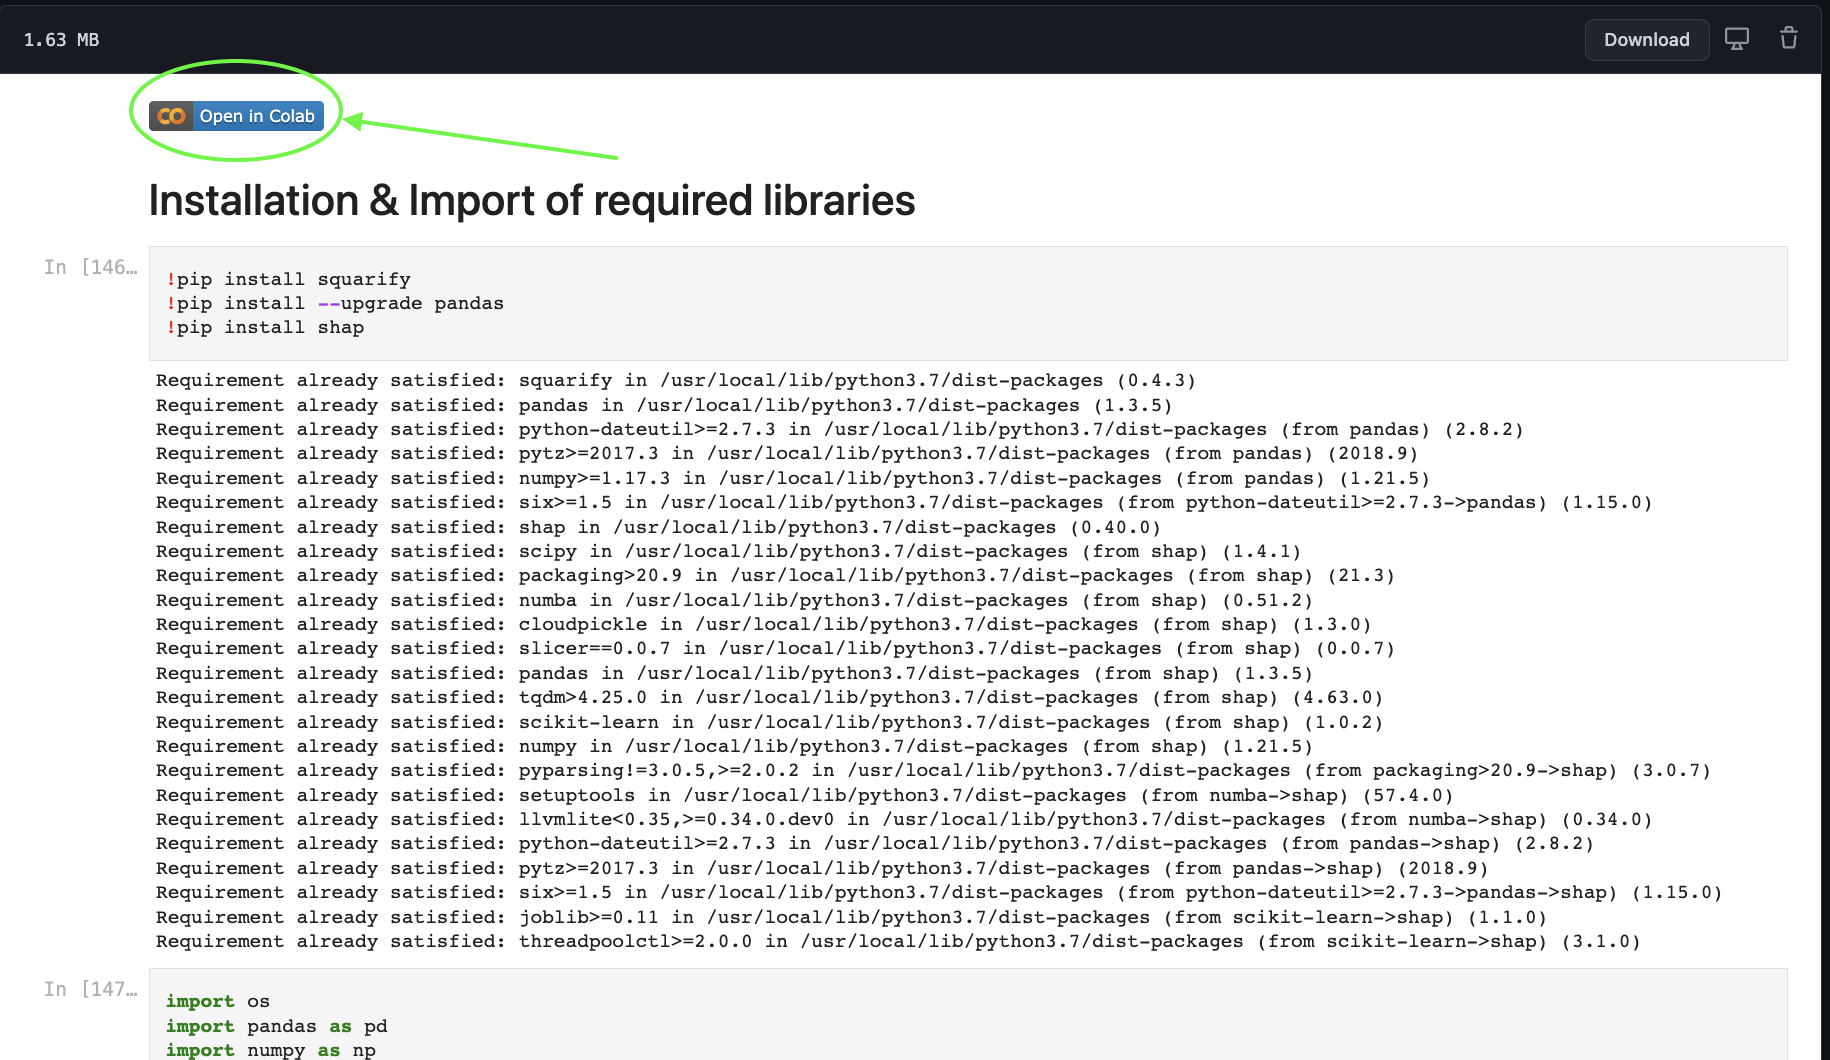

**Result:**

Here distribution of listed apartments all around New York. 

*Blue points* represent - apartments that cost 0$ - 999 999$

*Green points* represent - apartments that cost 999 999$ - 1 999 999$

*Red points* represent - apartments that cost 1 999 999$ - 2 999 999$

*Yellow points* represent - apartments that cost 2 999 999$ - 3 999 999$

*Orange points* represent - apartments that cost 3 999 999$ - 4 999 999$

*Black points* represent - apartments that cost 4 999 999$ - 10 000 000$ 

*Brown points* represent - apartments that cost 10 000 000$ - 20 000 000$



---

**Result:**

Here it is easier to visualize, where apartments are located. Main cluster of apartments located in Manhattan region. Other apartments are scattered all around New York, but mainly to the East of the city and it is mainly apartments that cost 0 $ - 1 999 999$. Also, here it is verified that all expensive apartments that are being represented by black marks are located in Manhattan region. But also, big cluster of green marks with blue marks are also located in this region.

In [ ]:
# IN ORDER TO VIEW GEOSPATIAL DATA ANALYSIS PLEASE USE BUTTON IN THE TOP CALLED "OPEN IN GOOGLE COLAB".
#Github does not allow to open maps from Folium just in the github, and thinks that it is not secure.

location = df['latitude'].mean(), df['longitude'].mean()
map_NY = folium.Map(location=location,
                    tiles='Stamen Terrain',
                    zoom_start=11)

for i in range(0,len(df)):
    num_of_price = df['price'].iloc[i]
    if num_of_price > 0 and num_of_price < 999999:
        color = 'blue'
    elif num_of_price > 999999 and num_of_price < 1999999:
        color = 'green'
    elif num_of_price > 1999999 and num_of_price < 2999999:
        color = 'red'
    elif num_of_price > 2999999 and num_of_price < 3999999:
      color='yellow'
    elif num_of_price > 3999999 and num_of_price < 4999999:
      color='orange'
    elif num_of_price > 4999999 and num_of_price < 10000000:
      color = 'black'
    elif num_of_price > 10000000 and num_of_price < 20000000:
      color ='brown'
    
    folium.Marker([df['latitude'].iloc[i],df['longitude'].iloc[i]],popup='Pricing',icon=folium.Icon(color=color, icon='info-sign')).add_to(map_NY)

map_NY


**Heatmap of apartments in New York**

In [ ]:
# IN ORDER TO VIEW GEOSPATIAL DATA ANALYSIS PLEASE USE BUTTON IN THE TOP CALLED "OPEN IN GOOGLE COLAB".
#Github does not allow to open maps from Folium just in the github, and thinks that it is not secure.

import folium.plugins as plugins
data_heat = df[['latitude', 'longitude', 'price']].values.tolist()
m = folium.Map(location=location, zoom_start=11)
plugins.HeatMap(data_heat).add_to(m)

m

**RESULT:**

There is clear correlationship between Living Area and Bedrooms, which makes sense



In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=df['year_built'], y=df['living_area'], z=df['bedrooms'], mode='markers',
                                   marker=dict(size=12, color=df['price'],
                                               colorscale='dense',
                                               opacity=0.8))])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show(renderer='colab')

# Feature Engineering 

Here latitude and longitude features are used for making distance feature to Empire State Building. It has resulted in better scores during building models. In comments there is other coordinates that were also tested and used ( Empier State Building, Main Railway Station, John F. Kennedy International Airport, Entry to Central Park ) 

In [ ]:
df['latitude_empier_state_building'] =40.748500421093865
df['longitude_empier_state_building'] = -73.98556979674355
#40.748500421093865, -73.98556979674355 Empier State Building 
# 40.752640832162534, -73.97738783463491 - Main Railway station
# 40.64957748302697, -73.79345274856009 - John F. Kennedy International Airport
# 40.7671676305183, -73.97889716461052 - Entry to Central Park

def haversine_vectorize(lon1, lat1, lon2, lat2): # Reference: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 3958 * dist #6367 for distance in KM for miles use 3958 # was 6367 = TOP 
    return km

df['distance'] = haversine_vectorize(df['longitude'], df['latitude'], df['longitude_empier_state_building'], df['latitude_empier_state_building'])

In [ ]:
df = df[['price', 'living_area', 'bathrooms', 'bedrooms', 'property_tax_rate', 'time_on_zillow', 'year_built', 'page_view_count', 'city_region', 'cooling', 'view', 'rent_estimate', 'annual_insurance' , 'distance']]
df['bathrooms'] = df['bathrooms'].astype('int64')
df['bedrooms'] = df['bedrooms'].astype('int64')

fig, ax = plt.subplots(figsize=(12,10))
corr = df.corr()
mask=np.triu(np.ones_like(corr, dtype=np.bool))
mask=mask[1:, :-1]
corr=corr.iloc[1:,:-1].copy()
ax=sns.heatmap(corr, mask=mask, vmin=-0.9, center=0, vmax=0.9, annot=True, fmt='.2f', linewidths=3,
               cmap='GnBu_r', annot_kws={"fontsize":12})
ax.set_title('Correlation Matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
fig.show()

In [ ]:
# annual_insurance and rent_estimate- are not used due to (it is zillow price algorithm that tries to build it is own prices. Also insurance companies use their own algorightms to predict, therefore it is highly correlated
# page_view_count not used due to having so low value

# Preprocessing dataframe for building models

**Result:**
*df_features* - dataframe that consists of features that will be used in building models and testing.

`annual_insurance` and `rent_estimate` are not used in *df_features* for predicting as it is algorithms that zillow uses to build and predict their own metrics, and `annual_insurance` uses metrics that are predicted by insurance companies, therefore it can not be used in final model. From `bathrooms` and `bedrooms` one column should be choosen because of high score in pearson correlation to avoid collinearity of features.

In [ ]:
#3.5. Remove collinear features
df_features = df[['living_area' ,'year_built', 'property_tax_rate', 'bathrooms', 'view', 'cooling','city_region', 'distance','price']] # if remains high error = remove living_area # listed by added # 'living_area' ,'year_built', 'property_tax_rate', 'bathrooms', 'view', 'cooling','city_region', 'distance','price'
df_features.rename(columns={'price':'target'}, inplace=True, errors='ignore') 

df_features.head()
df_features.shape

In [ ]:
df_features['cooling'] = df['cooling'].astype('object')
df_features['view'] = df['view'].astype('object')
X = df_features.drop('target', axis=1)
y = df_features['target']

num_cols = ['living_area', 'year_built', 'property_tax_rate', 'bathrooms', 'distance']
cat_cols = ['cooling', 'view', 'city_region']
cat_features = ['cooling', 'view', 'city_region']

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(X[cat_features])
encoded_cols = list(encoder.get_feature_names(cat_features))
X[encoded_cols] = encoder.transform(X[cat_features])
X.drop(['cooling', 'view', 'city_region'], axis=1 , inplace=True)
pd.DataFrame(X, columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
scaler = RobustScaler() # Robust Scaler is used to reduce effect of outliers
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train = pd.DataFrame(X_train, columns=X.columns).reset_index()
X_test = pd.DataFrame(X_test, columns=X.columns).reset_index()

# Baseline models

In [ ]:

def metrics(valid, pred):
  mse = mean_squared_error(valid, pred)
  rmse = np.sqrt(mean_squared_error(valid, pred))
  mae = mean_absolute_error(valid,pred)
  return mse, rmse, mae

#LinearRegression
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

df_models = pd.DataFrame(data=[['Linear Regression', *metrics(y_test, y_pred)]], columns=['Model Name', 'MSE', 'RMSE', 'MAE'])
# Lasso
model = Lasso().fit(X_train, y_train)
y_pred = model.predict(X_test)

df_models_temp = pd.DataFrame(data=[['Lasso', *metrics(y_test, y_pred)]], columns=['Model Name', 'MSE', 'RMSE', 'MAE'])
df_models = df_models.append(df_models_temp, ignore_index=True)
# Ridge
model = Ridge().fit(X_train, y_train)
y_pred = model.predict(X_test)

df_models_temp = pd.DataFrame(data=[['Ridge', *metrics(y_test, y_pred)]], columns=['Model Name', 'MSE', 'RMSE', 'MAE'])
df_models = df_models.append(df_models_temp, ignore_index=True)
# Random Forest	
clf = RandomForestRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

df_models_temp = pd.DataFrame(data=[['Random Forest', *metrics(y_test, y_pred)]], columns=['Model Name', 'MSE', 'RMSE', 'MAE'])
df_models = df_models.append(df_models_temp, ignore_index=True)
#Decision Tree Regressor
model = DecisionTreeRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

df_models_temp = pd.DataFrame(data=[['Decision Tree Regressor', *metrics(y_test, y_pred)]], columns=['Model Name', 'MSE', 'RMSE', 'MAE'])
df_models = df_models.append(df_models_temp, ignore_index=True)

# Gradient Boosting Regressor
model = GradientBoostingRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)

df_models_temp = pd.DataFrame(data=[['Gradient Boosting Regressor', *metrics(y_test, y_pred)]], columns=['Model Name', 'MSE', 'RMSE', 'MAE'])
df_models = df_models.append(df_models_temp, ignore_index=True)

# Ada Boosting Regressor

model = AdaBoostRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)
df_models_temp = pd.DataFrame(data=[['Ada Boosting Regressor', *metrics(y_test, y_pred)]], columns=['Model Name', 'MSE', 'RMSE', 'MAE'])


In [ ]:
df_models = df_models.append(df_models_temp, ignore_index=True)
df_models.sort_values('RMSE').reset_index(drop=True)

In [ ]:
df_models_temp = df_models.sort_values('RMSE', ascending=False).reset_index(drop=True)
bar_data = go.Bar(x=df_models_temp['RMSE'], y=df_models_temp['Model Name'], orientation='h', opacity=0.6, marker=dict(color='rgb(158,202,225)'))
data = [bar_data]
layout = go.Layout(title='Models sorted per RMSE', xaxis={'title':'RMSE'}, yaxis={'title':'Model'})
figure = go.Figure(data=data, layout=layout)
figure.show(renderer="colab")

# Fine tuning

In [ ]:
def timer(start_time=None):
  if not start_time:
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params ={
    'max_depth':[5, 6, 7, 8, 9],
    'learning_rate': [0.25, 0.3, 0.4, 0.5, 0.6],
    'n_estimators': [300, 400, 500, 600, 700],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7]
}

#folds = 10
#model = GradientBoostingRegressor()
#kf = KFold(n_splits=folds, shuffle=True, random_state=1)
#random_search = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", n_jobs=-1, cv=kf.split(X,y), verbose=3)

#start_time = timer(None)
#random_search.fit(X,y)
#timer(start_time)


In [ ]:
#print('\n All results:')
#print(random_search.cv_results_)
#print('\n')
#print('*'*80)
#print('*'*80)
#print('\n Best Estimator:')
#print(random_search.best_estimator_)
#print('\n')
#print('*'*80)
#print('*'*80)
#print('\n Best hyperparameters:')
#print(random_search.best_params_)


 All results:
{'mean_fit_time': array([0.24217477, 0.26565919, 0.27389359, 0.28236618, 0.29312613,
       0.33352132, 0.34177017, 0.35457659, 0.37159109, 0.523212  ,
       0.41654339, 0.65992713, 0.79646738, 0.79864509, 0.78087122,
       0.73501387, 0.79336884, 0.53348348, 0.54150937, 0.5769423 ,
       0.56772525, 0.59165604, 0.61531942, 0.6303158 , 0.65563803,
       0.25472829, 0.27214553, 0.28025973, 0.28923674, 0.30302765,
       0.52544954, 0.35426905, 0.37324367, 0.38919792, 0.4356415 ,
       0.42630758, 0.58131158, 0.79878938, 0.89879498, 0.91367724,
       1.05854313, 0.96428084, 1.05419271, 1.06260383, 1.1870146 ,
       1.00622025, 1.00406458, 1.23387032, 1.33487375, 1.1985188 ,
       0.41382802, 0.45401769, 0.47212543, 0.48777204, 0.59237731,
       0.35069244, 0.36819918, 0.39296949, 0.40638261, 0.42593794,
       0.44316235, 0.4551465 , 0.48217125, 0.49952748, 0.51895504,
       0.52514863, 0.54657862, 0.56878068, 0.59375651, 0.612009  ,
       0.59628699, 0.64015608

In [ ]:
model_final = GradientBoostingRegressor(learning_rate=0.375, max_depth=9, 
                                  n_estimators=425,  subsample=0.7, random_state=2).fit(X_train, y_train) 
y_pred = model_final.predict(X_test)

df_final_model = pd.DataFrame(data=[['Gradient Boosting Regressor', *metrics(y_test, y_pred)]], columns=['Model Name', 'MSE', 'RMSE', 'MAE']) # i just applied 10 folds not 6, to reutnr results use 6
df_final_model  # learning_rate=0.375, max_depth=9, n_estimators=425,  subsample=0.7, random_state=2

SyntaxError: ignored

# Interpretability

In [ ]:
#SHAP
import shap
explainer = shap.Explainer(model_final)
shap_values = explainer(X_train)

shap.plots.bar(shap_values, max_display=13)
fig = plt.gcf()
fig.set_figheight(11)
fig.set_figwidth(9)
plt.show()

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.heatmap(shap_values[1:80])
fig = plt.gcf()
fig.set_figheight(11)
fig.set_figwidth(9)
plt.show()

In [ ]:
expected_value = explainer.expected_value
print("The expected value is ", expected_value)
shap_values = explainer.shap_values(X_train)[15] # random row used for plotting  Interpretability
shap.decision_plot(expected_value, shap_values, X_test)

In [ ]:
expected_value = explainer.expected_value
print("The expected value is ", expected_value)
shap_values = explainer.shap_values(X_train)[25] # random row used for plotting  Interpretability
shap.decision_plot(expected_value, shap_values, X_test)